# Pre-process of tracks from Free Music Archive 

In [1]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import librosa
import librosa.display
import warnings
import gc
import os

from utils_mgr import get_mel, clip_mel, DataAudio, getAudio, display_mel

from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, v2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adadelta, Adam
from tensorboard.backend.event_processing import event_accumulator
import pytorch_lightning as pl

import random
import utils
import utils_mgr

2024-01-18 14:36:18.012644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')

#Check tracks format
tracks.shape 

(106574, 52)

# Audio

In [4]:
#Function getAudio to extract tracks from .mp3 file
x_ex = utils_mgr.getAudio(2)

#Print some track features
print(x_ex[1])
duration_seconds = x_ex[0].shape[-1] / x_ex[1]
print(f'Duration: {duration_seconds:.2f}s, {x_ex[0].size} samples')

# Play a segment of the audio (Clip that will be used as Cnn input)
start, end = 15, 21
ipd.Audio(data=x_ex[0][start * x_ex[1] : end * x_ex[1]], rate=x_ex[1])

44100
Duration: 29.98s, 1321967 samples


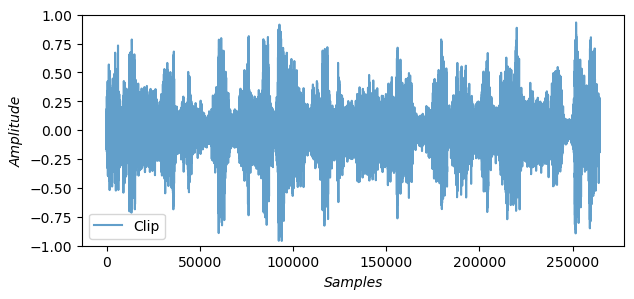

In [5]:
# Create another plot for a segment of the audio signal
plt.figure(figsize=(7, 3))
plt.plot(x_ex[0][start * x_ex[1] : end * x_ex[1]], label='Clip', alpha =0.7) 
plt.ylim((-1, 1))
plt.xlabel('Samples', fontstyle = 'italic')
plt.ylabel('Amplitude', fontstyle = 'italic')
plt.legend()

plt.show()

## Compute stft and mel spectrogram


In [11]:
# Compute the short-time Fourier transform (stft)
stft_ex = np.abs(librosa.stft(x_ex[0][start * x_ex[1] : end * x_ex[1]], n_fft=4096, hop_length=2048))

# Convert the power spectrogram to decibels
log_stft_ex = librosa.amplitude_to_db(stft_ex)


mel = librosa.feature.melspectrogram(sr=x_ex[1], S=stft_ex**2, n_mels=513)[:,:128]
mel = librosa.power_to_db(mel)

Original mel spectrogram (transpose shape is:  (129, 128)


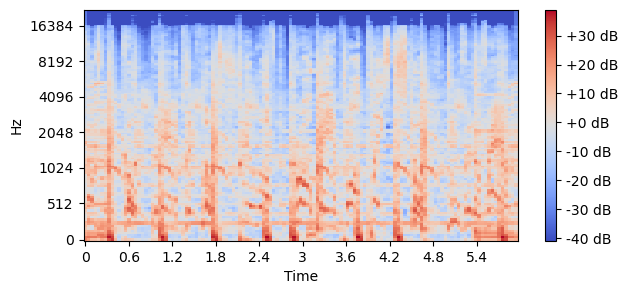

0

In [11]:
#check for mel properties depending on different settings

display_mel(idx=2, n_samples=2**18, n_fft=4096, n_mels=128, time_bin=265, sr_i=None)

### Creation of training, test and validation sets with metadata

In [13]:
#Select the desired subset among the entire dataset
sub = 'small'
raw_subset = tracks[tracks['set', 'subset'] <= sub]

In [14]:
#Location of labels of interest for classification
labels = raw_subset['track']['genre_top']
labels = np.array(labels)

In [16]:
#Creation of clean subset for the generation of training, test and validation sets

meta_subset= utils_mgr.create_subset(raw_subset)

In [41]:
meta_subset[:10]


,index,genre_top,split,labels
0,2,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,5,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,10,Pop,training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,140,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,141,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,148,Experimental,validation,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,182,Rock,test,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7,190,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,193,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,194,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [99]:
SPLIT = False

#Creation of Audio datasets with full extracted arrays
#Check also integrity of mp3 files during extraction
if SPLIT == True:
    test = utils_mgr.splitAudio(meta_subset, 'test')

In [102]:

if SPLIT == True:
    training = utils_mgr.splitAudio(meta_subset, 'training')
    validation = utils_mgr.splitAudio(meta_subset, 'validation')

problems with song:  98565
problems with song:  98567
problems with song:  98569
problems with song:  99134
problems with song:  108925
problems with song:  133297


In [108]:
#Save heavy array into multiple npy files. The full dataset will still be useful to derive quantity such as mean and std

utils_mgr.saveheavy(test, 'test', 2)
utils_mgr.saveheavy(validation, 'validation', 2)
utils_mgr.saveheavy(training, 'training', 16)

In [2]:
#Reload heavy dataset from .npy files

validation = utils_mgr.readheavy('validation', 1, 'data/audio_array')
#training= utils_mgr.readheavy('training', 16, 'data/audio_array')
#test= utils_mgr.readheavy('test', 2, 'data/audio_array')

In [3]:
#Estimate mean and std of the datasets elements, they will be used for normalization purposes
#(validation is here use as significative example)

mean1D, std1D = utils_mgr.mean_1D(validation)
mean2D, std2D = utils_mgr.mean_2D_mel(validation)

print('Media mel: ', mean2D)
print('Std mel: ', std2D)

making clips


Processing clips: 100%|██████████| 400/400 [00:00<00:00, 11651.33it/s]

making clips
stacking


getting stft
making clips
making clips
stacking
Media mel:  1.1678228
Std mel:  4.236892


In [ ]:
#Restarting from meta_dataset containing metadata remove corrupted tracks

corrupted = [98565, 98567, 98569, 99134, 108925, 133297]
meta_subset = meta_subset[~meta_subset['index'].isin(corrupted)]

In [ ]:
#split into training, validation and test set accoridng to original FMA split

train_set = meta_subset[meta_subset["split"] == "training"]
val_set   = meta_subset[meta_subset["split"] == "validation"]
test_set  = meta_subset[meta_subset["split"] == "test"]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

# Creation of Dataset class

In [ ]:
#Creation of custom class for the extraction of samples to be used as input for torch networks


class DataAudio(Dataset):

    def __init__(self, df, transform = None, type = "1D"):
        
        # Get track index
        self.track_ids = df['index'].values

        #Get genre label
        self.label = df['labels'].values

        #Transform
        self.transform = transform

        #Select type of input
        self.type = type

    def __len__(self):

        return len(self.track_ids)

    def create_input(self, i):
      
        # Get audio        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            audio, sr = getAudio(self.track_ids[i])

            #Select random clip from audio
            start = np.random.randint(0, (audio.shape[0]-2**18))
            audio = audio[start:start+2**18]
            
            if(self.type=="2D"):
                #Get 2D spectrogram
                stft = np.abs(librosa.stft(audio, n_fft=4096, hop_length=2048))              
                mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=513)[:,:128]
                mel = librosa.power_to_db(mel).T
                return mel
            
            return audio[np.newaxis,:]       
            
    def __getitem__(self, idx):
        # get input and label
        try:
            x = self.create_input(idx)
            y = self.label[idx] 
        except:
            print("\nNot able to load track number ", self.track_ids[idx], " Loading next one\n")
            x = self.create_input(idx+1)
            y = self.label[idx]
        
        if self.transform:
            x = self.transform(x)
           
        return x,y

## Metrics definition

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

'''
Function to compute terms for the evaluation of confusion matrix and different metrics:

TP: True Positive, the cases in which we predicted YES and the actual output was also YES.
FP: False Positive, the cases in which we predicted YES and the actual output was NO.
TN: True Negative, the cases in which we predicted NO and the actual output was also NO.
FN: False Negative, the cases in which we predicted NO and the actual output was YES.
'''

def compute_CM_terms(out_net, label_batch):

    out_pred = out_net.argmax(dim=1)


    out_pred_bool = F.one_hot(out_pred, num_classes=8).bool()
    
    # logical_and is element wise 'and', zeros element are always false
    # 0 == 0 -> False
    TP = torch.logical_and(out_pred_bool, label_batch).sum(dim=0)
    FP = torch.logical_and(out_pred_bool, ~label_batch).sum(dim=0)
    TN = torch.logical_and(~out_pred_bool, ~label_batch).sum(dim=0)
    FN = torch.logical_and(~out_pred_bool, label_batch).sum(dim=0)
    
    
    return TP, FP, TN, FN

In [ ]:
def compute_metrics(TP, FP, TN, FN):

    # Compute metrics
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

# Baseline: 1D CNN 

In [1]:
#Dataset transformation

# Standard transformations for images
    
transforms = v2.Compose([torch.Tensor,
                         lambda x: x/std1D])  #To normalize data

In [ ]:
# Create the datasets and the dataloaders, num_workers=8 is related to computational power of the running machine
train_dataset    = DataAudio(train_set, transform = transforms, type='1D')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)

val_dataset      = DataAudio(val_set, transform = transforms, type='1D')
val_dataloader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

test_dataset     = DataAudio(test_set, transform = transforms, type='1D')
test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [ ]:
'''
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
                                        TRY DEEEPER NETWORKS WITH MORE PARAMETERS
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
'''


class NNET1D(nn.Module):
        
    def __init__(self):
        super(NNET1D, self).__init__()
        
        
        self.c1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=128, stride=32, padding=64),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(p=0.2),
        )

        self.c2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=32, stride=2, padding=16),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )

        self.c3 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=2, padding=8),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )
        
        #Trying to add 4th convolutional block
        self.c4 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8,stride=2, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2)
        )
        

        self.fc = nn.Sequential(
            nn.Linear(265, 128), 
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2),
            nn.Linear(64, 8),
            nn.Softmax(dim=1)
        )

    def forward(self, x):

        c1 = self.c1(x)  
        c2 = self.c2(c1) 
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        max_pool = F.max_pool1d(c4, kernel_size=64)
        avg_pool = F.avg_pool1d(c4, kernel_size=64)

        #Concatenate max and average pooling
        x = torch.cat([max_pool, avg_pool], dim = 1) 
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        
        return x 

In [ ]:
# Define a general LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    
    def __init__(self, model_net, optimizer, lr=1, config=None):
       
        super().__init__()
        # super(NNET2, self).__init__() ? 
        
        print('Network initialized')
        
        self.net = model_net
        self.val_loss = []
        self.train_loss = []
        self.best_val = np.inf
        
        '''
        /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
                                                    TRY DIFFERENT OPTIMIZERS (ADAM, SGD WITH MOMENTUM)
        '''
    # If no configurations regarding the optimizer are specified, use the default ones
        try:
            self.optimizer = Adadelta(self.net.parameters(),
                                       lr=config["lr"],rho=config["rho"], eps=config["eps"], weight_decay=config["weight_decay"])
        except:
                print("Using default optimizer parameters")
                self.optimizer = optimizer(self.net.parameters(), lr = lr)
        '''
        /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        '''




    def forward(self,x):
        return self.net(x)

    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.cross_entropy(out, label_batch) # Diego nota: aggiungere weights in base a distribuzione classi dataset?
        self.train_loss.append(loss.item())

        #Evaluation of metrics

        TP, FP, TN, FN = compute_CM_terms(out, label_batch)
        accuracy, precision, recall, specificity, f1 = compute_metrics(TP, FP, TN, FN)

        train_acc = accuracy.mean()
        train_prec = precision.mean()
        train_rec = recall.mean()
        train_spec = specificity.mean()
        train_f1 = f1.mean()
        print("Train accuracy: ", train_acc)
        print("Train precision: ", train_prec)
        print("Train recall: ", train_rec)
        print("Train specificity: ", train_spec)
        print("Train f1: ", train_f1)
        print("\n")

        self.log("train_loss", loss.item(), prog_bar=True)
        self.log("train_acc", train_acc, prog_bar=True)
        self.log("train_prec", train_prec, prog_bar=True)
        self.log("train_rec", train_rec, prog_bar=True)
        self.log("train_spec", train_spec, prog_bar=True)
        self.log("train_f1", train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx=None):
        # validation_step defines the validation loop. It is independent of forward
        # When the validation_step() is called,
        # the model has been put in eval mode and PyTorch gradients have been disabled. 
        # At the end of validation, the model goes back to training mode and gradients are enabled.
        x_batch = batch[0]
        label_batch = batch[1]

        out = self.net(x_batch)
        loss = F.cross_entropy(out, label_batch)

        #Evaluation of metrics 

        TP, FP, TN, FN = compute_CM_terms(out, label_batch)
        accuracy, precision, recall, specificity, f1 = compute_metrics(TP, FP, TN, FN)

        val_acc = accuracy.mean()
        val_prec = precision.mean()
        val_rec = recall.mean()
        val_spec = specificity.mean()
        val_f1 = f1.mean()
        print("Validation accuracy: ", val_acc)
        print("Validation precision: ", val_prec)
        print("Validation recall: ", val_rec)
        print("Validation specificity: ", val_spec)
        print("Validation f1: ", val_f1)
        print("\n")
        
        # Save best model

        if loss.item() < self.best_val:
            self.best_val = loss.item()
            torch.save(self.net.state_dict(), 'best_model.pt')
            print("Best model saved")    

        self.val_loss.append(loss.item())
        self.log("val_loss", loss.item(), prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        self.log("val_prec", val_prec, prog_bar=True)
        self.log("val_rec", val_rec, prog_bar=True)
        self.log("val_spec", val_spec, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.cross_entropy(out, label_batch)

        #test_acc = np.sum(np.argmax(label_batch.detach().cpu().numpy(), axis=1) == np.argmax(out.detach().cpu().numpy(), axis=1)) / len(label_batch)

        #Try new metrics

        TP, FP, TN, FN = compute_CM_terms(out, label_batch)
        accuracy, precision, recall, specificity, f1 = compute_metrics(TP, FP, TN, FN)

        test_acc = accuracy.mean()
        test_prec = precision.mean()
        test_rec = recall.mean()
        test_spec = specificity.mean()
        test_f1 = f1.mean()
        print("Test accuracy: ", test_acc)
        print("Test precision: ", test_prec)
        print("Test recall: ", test_rec)
        print("Test specificity: ", test_spec)
        print("Test f1: ", test_f1)
        print("\n")
        
        self.log("test_loss", loss.item(), prog_bar=True)
        self.log("test_acc", test_acc, prog_bar=True)

    def configure_optimizers(self):

        return self.optimizer

In [ ]:
#Function for main training of the network

def main_train(max_epochs, model_net, optimizer=Adam,  lr=1, config=None):
    pl.seed_everything(0)
      
    # Define the EarlyStopping callback
    early_stop_callback = pl.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.01,     # Minimum change in the monitored metric
        patience=10,          # Number of epochs with no improvement after which training will be stopped
        verbose=True,
        mode='min'           # Mode: 'min' if you want to minimize the monitored quantity (e.g., loss)
    )

    trainer = pl.Trainer(max_epochs=max_epochs, check_val_every_n_epoch=5, log_every_n_steps=1, 
                         deterministic=True,callbacks=[early_stop_callback], ) # profiler="simple" remember to add this and make fun plots
    
    model = LitNet(model_net, lr=lr, config=config)

    trainer.fit(model, train_dataloader, val_dataloader)
    trainer.test(model=model,dataloaders=test_dataloader,verbose=True)

    return model

In [ ]:
#Training of 1D Cnn baseline

LitNet1D = main_train(100, NNET1D(), lr=0.5)

In [25]:
#Define plot functions

def extract_scalar_events(event_file_path):
    ea = event_accumulator.EventAccumulator(event_file_path)
    ea.Reload()

    data = {
        tag: [event.value for event in ea.scalars.Items(tag)]
        for tag in ea.Tags()['scalars']
    }

    df = pd.DataFrame(data)
    return df
  
def plot_metrics(df):
    plt.figure(figsize=(10, 5))

    # Plot val_acc vs epoch
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['val_acc'], marker='o', markersize=2, label='val_acc', color='indianred')
    plt.plot(df['epoch'], df['train_acc'], marker='o', markersize=2, label='train_acc', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    # Plot loss vs epoch
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['val_loss'], marker='o', markersize=2,  label='val_loss', color='indianred')
    plt.plot(df['epoch'], df['train_loss'], marker='o', markersize=2, label='train_loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(2,2,1)
    plt.plot(df['epoch'], df['val_prec'], marker='o', markersize=2, label='val_prec', color='indianred')
    plt.plot(df['epoch'], df['train_prec'], marker='o', markersize=2, label='train_prec', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.grid()
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(df['epoch'], df['val_rec'], marker='o', markersize=2, label='val_rec', color='indianred')
    plt.plot(df['epoch'], df['train_rec'], marker='o', markersize=2, label='train_rec', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.grid()
    plt.legend()

    plt.subplot(3,2,1)
    plt.plot(df['epoch'], df['val_spec'], marker='o', markersize=2, label='val_spec', color='indianred')
    plt.plot(df['epoch'], df['train_spec'], marker='o', markersize=2, label='train_spec', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Specificity')
    plt.grid()
    plt.legend()

    plt.subplot(3,2,2)
    plt.plot(df['epoch'], df['val_f1'], marker='o', markersize=2, label='val_f1', color='indianred')
    plt.plot(df['epoch'], df['train_f1'], marker='o', markersize=2, label='train_f1', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(TP, FP, TN, FN):
    # Compute confusion matrix
    cm = np.array([[TN, FP],[FN, TP]])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xticks([0,1], ['NO', 'YES'])
    plt.yticks([0,1], ['NO', 'YES'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


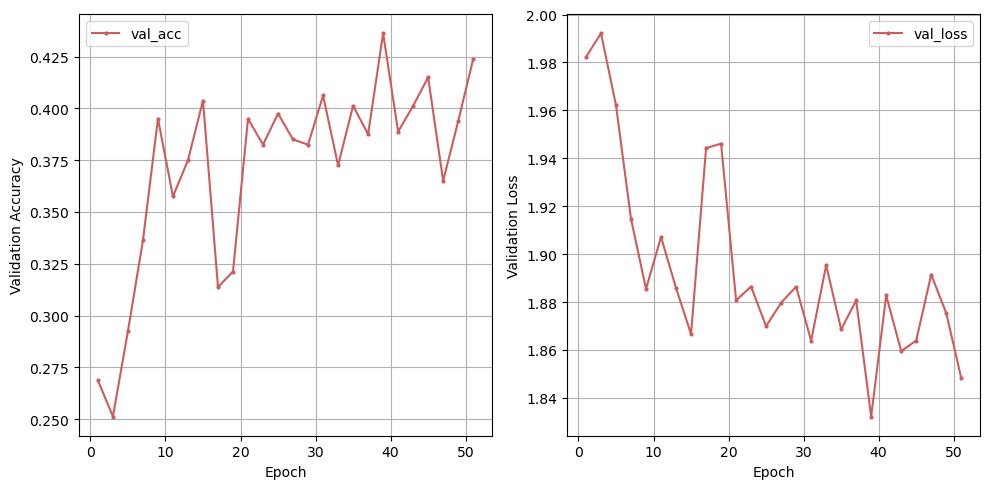

In [26]:
result1D_path = 'lightning_logs_1D_Final/version_21/events.out.tfevents.1705188023.LAPTOP-9G4PBER8.586405.0'
df_1D = extract_scalar_events(result1D_path)
plot_metrics(df_1D)

# Baseline: 2D CNN

In [ ]:
'''
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
                        MODIFY THE TRANSFORMATIONS OF THE DATASET (NO STRETCHING OR CROPPING)
'''
#Dataset transformation

# Standard transformations for images
    
transforms = v2.Compose([MinMaxScaler().fit_transform,
                         v2.ToTensor(),
                         v2.RandomResizedCrop(size=(128,513), antialias=True), # Data Augmentation
                         v2.RandomHorizontalFlip(p=0.5), # Data Augmentation !!!!
                         v2.ToDtype(torch.float32, scale=True), 
                        ])

'''
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
'''

In [ ]:
# Create the datasets and the dataloaders
train_dataset    = DataAudio(train_set, transform = transforms,type='2D')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())

val_dataset      = DataAudio(val_set, transform = transforms,type='2D')
val_dataloader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

test_dataset     = DataAudio(test_set, transform = transforms,type='2D')
test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

In [ ]:
class NNET2(nn.Module):
        
    def __init__(self,initialisation="xavier"):
        super(NNET2, self).__init__()
        
        
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256,kernel_size=(4,513)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(.2)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(2,0)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(.2)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(1,0)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(.2)
        )
               

        self.fc = nn.Sequential(
            nn.Linear(512, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, 8),
            nn.Softmax(dim=1)
        )

        # Weights initialisation
        # if
        if initialisation == "xavier":
            print("initialising weights with Xavier")
            self.apply(self._init_weights)
        else:
            print('Weights not initialised. If previous checkpoint is not loaded, set initialisation = "xavier"')


    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self,x):
        
        c1 = self.c1(x) 
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        x = c1 + c3

        max_pool = F.max_pool2d(x, kernel_size=(125,1))
        avg_pool = F.avg_pool2d(x, kernel_size=(125,1))

        x = torch.cat([max_pool,avg_pool],dim=1)
        x = self.fc(x.view(x.size(0), -1)) # Reshape x to fit in linear layers. Equivalent to F.Flatten
        
        return x 


In [ ]:
#Traininf of 1D Cnn baseline

LitNet2D = main_train(100, NNET2(initialisation='xavier'), lr=0.5)

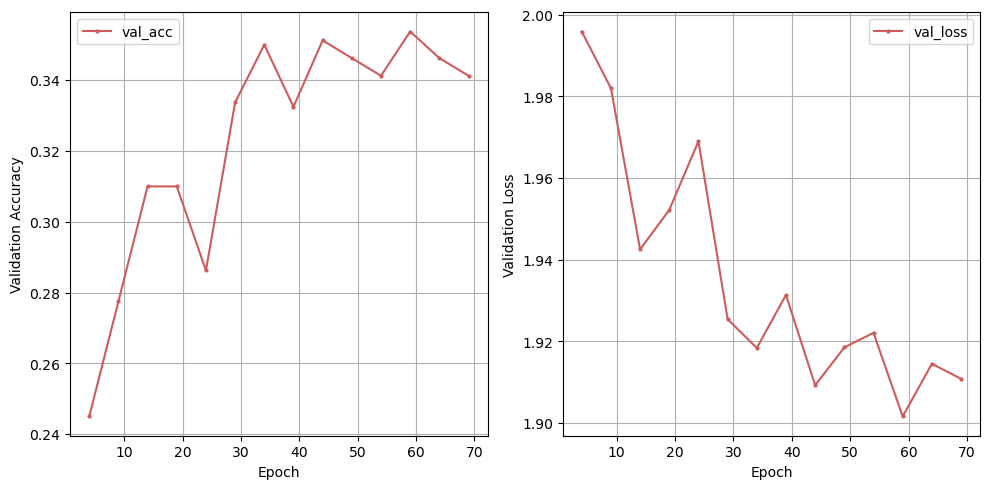

In [27]:
#Plot training results, lr = 0.5

result2D_path = 'lightning_logs_2D_Final/version_4/events.out.tfevents.1705015986.PC-Diego.21889.0'
df_2D = extract_scalar_events(result2D_path)
plot_metrics(df_2D)

# Transfer Learning:  CNN 1D + CNN 2D (Freeze weights)
Goal: use already trained architectures to train a new classifier that gets information both from 1D and 2D data (raw audio + mel spectrogram).
To do list:

- Load the trained models and their weights
- Set the model to evaluation mode and freeze their parameters in order not to track their gradients. We want to just use the models and train the classifier only
- Build the new model:

    - Extract CNN layers from NNET1D and NNET2D
    - Create a new MixNet class that import these layers and adds a fully-connected block to their outputs.

## Load trained architectures 

In [ ]:
#New dataset class for the extraction of audio, mel spectrograms and labels

class DataAudio_double(Dataset):

    def __init__(self, df, transform = None):
        
        # Get track index
        self.track_ids = df['index'].values

        #Get genre label
        self.label = df['labels'].values

        #Transform
        self.transform = transform

    def __len__(self):

        return len(self.track_ids)


    def create_input(self, i):
      
        # Get audio
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            audio, sr = getAudio(self.track_ids[i])

            #Select random clip from audio
            start = np.random.randint(0, (audio.shape[0]-2**18))
            audio = audio[start:start+2**18]
            
        
            #Get 2D spectrogram
            stft = np.abs(librosa.stft(audio, n_fft=4096, hop_length=2048))
            
            mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=513)[:,:128]
            mel = librosa.power_to_db(mel, ref=np.max).T
    
        
            return audio[np.newaxis,:], mel

In [ ]:
transforms = v2.Compose([MinMaxScaler().fit_transform,
                        v2.ToTensor(),
                        v2.RandomResizedCrop(size=(128,513), antialias=True), # Data Augmentation
                        v2.RandomHorizontalFlip(p=0.5), # Data Augmentation
                        v2.ToDtype(torch.float32, scale=True),
                        ])

In [ ]:
# Create the datasets and the dataloaders, batch size is here reduced due to computational feasability
    
train_dataset    = DataAudio_double(train_set, transform = transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)

val_dataset      = DataAudio_double(val_set, transform = transforms)
val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8)

test_dataset     = DataAudio_double(test_set, transform = transforms)
test_dataloader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

In [ ]:
# Load model weights from checkpoint
CKPT_PATH_1D = "./CNN1D/lightning_logs/version_21/checkpoints/epoch=69-step=7000.ckpt"
CKPT_PATH_2D = "./CNN2D/lightning_logs/version_4/checkpoints/epoch=69-step=7000.ckpt"

nnet1d = LitNet1D.load_from_checkpoint(checkpoint_path=CKPT_PATH_1D).eval()
nnet2d = LitNet2D.load_from_checkpoint(checkpoint_path=CKPT_PATH_2D).eval()

## Freeze the weights
Setting `requires_grad = False` will stop Pytorch to tracking the gradients of the CNNs layers

In [ ]:
FREEZE = False


if FREEZE == True:
    # Freeze the weights
    for param in nnet1d.parameters():
        param.requires_grad = False
        
    for param in nnet2d.parameters():
        param.requires_grad = False

## Extracting convolutional layers (testing..)

In [ ]:
# Get all convolutional layers from nnet2d
conv_layers = [layer for layer in nnet2d.modules() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.ReLU)]

# Build a new convolutional layer
conv_block2D = nn.Sequential(*conv_layers[:9]) # [:9] to remove redundat ReLU layers taken by mistake from fc layers

# Print the new convolutional layer
print(conv_block2D)

In [ ]:
# Get all convolutional layers from nnet1d
conv_layers = [layer for layer in nnet1d.modules() if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.ReLU)]

# Build a new convolutional layer
conv_block1D = nn.Sequential(*conv_layers[:12])

# Print the new convolutional layer
print(conv_block1D)

## Define the new model `MixNet`
**For the real final architecture look at the .py files.** At the end there may be many less layers.

In [ ]:
class MixNet(nn.Module):
    def __init__(self, conv_block1D, conv_block2D):
        super(MixNet, self).__init__()
        self.conv_block1D = conv_block1D
        self.conv_block2D = conv_block2D

        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer

        self.classifier = nn.Sequential(
            nn.Linear(512+2048, 512),
            nn.ReLU(),
            self.dropout, 
            nn.Linear(512, 256),
            nn.ReLU(),
            self.dropout, 
            nn.Linear(256, 128),
            nn.ReLU(),
            self.dropout,  
            nn.Linear(128, 8),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        audio = x[0]
        mel = x[1]
        
        conv2d = self.conv_block2D(mel)
        max_pool = F.max_pool2d(conv2d, kernel_size=(125,1))
        avg_pool = F.avg_pool2d(conv2d, kernel_size=(125,1))
        cat2d = torch.cat([max_pool,avg_pool],dim=1)
        cat2d = cat2d.view(cat2d.size(0), -1) # cat2d shape torch.Size([1, 512])
        
        conv1d = self.conv_block1D(audio)

        max_pool = F.max_pool1d(conv1d, kernel_size=125)
        avg_pool = F.avg_pool1d(conv1d, kernel_size=125)

        cat1d = torch.cat([max_pool,avg_pool],dim=1)
        cat1d = cat1d.view(cat1d.size(0), -1) # cat1d dim = torch.Size([batch_size, 2048])

        # Concatanate the two outputs and pass it to the classifier
        # cat1d dim = torch.Size([batch_size, 2048])
        # cat2d dim = torch.Size([batch_size, 512])
        x = torch.cat([cat1d, cat2d], dim=1) 
        x = self.dropout(x)  # Add dropout layer
        x = self.classifier(x)

        return x

In [ ]:
#Function for main training of the mix network

#Traininf of 1D Cnn baseline

LitNetMix = main_train(100, MixNet(conv_block1D=conv_block1D, conv_block2D=conv_block2D))

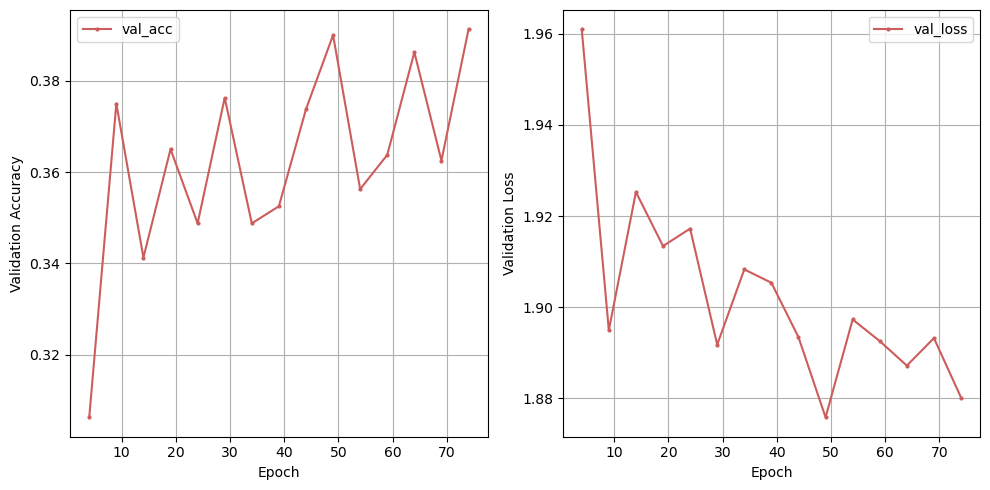

In [28]:
#Plot training results, lr = 0.5

resultMix_path = 'lightning_logs_mix_Final/version_20/events.out.tfevents.1705431025.LAPTOP-9G4PBER8.168393.0'
df_mix = extract_scalar_events(resultMix_path)
plot_metrics(df_mix)

# Spatial Transformer: 2D CNN implementation

In [ ]:
transforms = v2.Compose([MinMaxScaler().fit_transform,
                         v2.ToTensor(),
                         v2.RandomResizedCrop(size=(128,513), antialias=True), # Data Augmentation
                         v2.RandomHorizontalFlip(p=0.5), # Data Augmentation
                         v2.ToDtype(torch.float32, scale=True),
                        ])

In [ ]:
# Create the datasets and the dataloaders
train_dataset    = DataAudio(train_set, transform = transforms,type=architecture_type)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())

val_dataset      = DataAudio(val_set, transform = transforms,type=architecture_type)
val_dataloader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

test_dataset     = DataAudio(test_set, transform = transforms,type=architecture_type)
test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

In [ ]:
#Localisation net to be applied before convolutional 2D CNN

class LocalisationNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 28 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self,x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 28 * 124)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self,initialisation="xavier") :
        super().__init__()

        self.stn = LocalisationNet()
        self.net = NNET2(initialisation)

    def forward(self,x):
        x = self.stn(x)
        x = self.net(x)
        return x

In [ ]:
LitNetMix = main_train(100, SpatialTransformer(initialisation = 'xavier'))

# Autoencoder & Residual Autoencoder (trials...)

In [ ]:
# Residual encoder
class ResEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()   

        self.c1 = nn.Sequential(
             nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                                stride=2, padding=1),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
            
                        )       

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, 
                                stride=2, padding=0),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, 
                                stride=2, padding=1),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
        )


    def forward(self, x):
            
            c1 = self.c1(x)
            c2 = self.c2(c1)
            c3 = self.c3(c2)
            
            # Residual connection
            avg_pool = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))
            c1 = avg_pool(c1)
            x  = c1 + c3
            
            return x

In [ ]:
# Residual decoder
class ResDecoder(nn.Module):
    
    def __init__(self):
        super().__init__()   

        self.c1 = nn.Sequential(
             nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, 
                                stride=3, padding=1),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
            
                        )       

        self.c2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, 
                                stride=2, padding=0),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
        )

        self.c3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, 
                                stride=3, padding=1),
                        nn.Sigmoid(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(0.2),
        )


    def forward(self, x):
            
            c1 = self.c1(x)
            c2 = self.c2(c1)
            c3 = self.c3(c2)
            """
            Using interpolate to control the shapes of the tensors
            Since it's a decoder, it would be difficult to use add the first
            residual connection without using interpolate (c1 has to be not too big since it's the output of the encoded space)          """
            # Residual connection
            # Upsampling c1 to match c3 shape
            c1 = F.interpolate(c1, size= (133, 565), mode='bilinear', align_corners=False)
            x  = c1 + c3
            # Upsampling to match original input shape
            x = F.interpolate(x, size= (128,513), mode='bilinear', align_corners=False)
            
            return x


In [ ]:
# Residual autoencoder
class ResAE(nn.Module):
    
    def __init__(self, encoded_space_dim=32):
        super().__init__()   
        
        self.encoder = ResEncoder()
        self.decoder = ResDecoder()

         ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= 2048, out_features=512),
            nn.Sigmoid(),
            # Second linear layer
            nn.Linear(in_features=512, out_features=encoded_space_dim),
            nn.Sigmoid()
        )

        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= encoded_space_dim, out_features=512),
            nn.Sigmoid(),
            # Second linear layer
            nn.Linear(in_features=512, out_features=2048),
            nn.Sigmoid()
        )

        
    def forward(self, x):
        
        x = self.encoder(x)
        # Avg pooling for dimensional reduction
        x = F.avg_pool2d(x, kernel_size=(2,2)) # shape torch.Size([batch_size, 8, 8, 32])
        # Flatten
        x = torch.flatten(x, start_dim=1) # shape torch.Size([batch_size, 2048])
        # Linear section
        latent_space = self.encoder_lin(x)
        # Start decoding
        x = self.decoder_lin(latent_space)
        # Unflatten
        x = torch.unflatten(x,1,(8,8,32))
        # Decode
        x = self.decoder(x)
        # Apply sigmoid to force output between 0 and 1
        x = torch.sigmoid(x)
        return x